In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

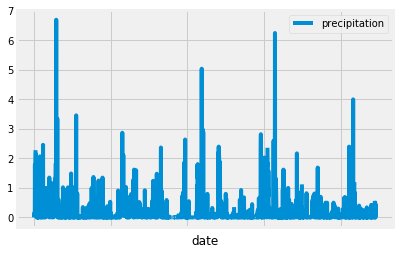

In [385]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago = one_year_ago.strftime("%Y-%m-%d")
df = pd.read_sql_query("select date, prcp as precipitation from measurement \
where date between '" + one_year_ago +  "' and '" + last_date + "' order by date", session.bind)
df = df.set_index('date')
df.plot()
plt.show()

In [160]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [161]:
# Design a query to show how many stations are available in this dataset?
station_counts = session.query(Measurement.station).distinct().count()
station_counts

9

In [163]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# st_df = pd.read_sql_query("""select station, count(*) as station_count
#                           from measurement group by station 
#                           order by station_count desc""", session.bind)
stations = session.query(Measurement.station, func.count(Measurement.station))\
            .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [166]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# active_temp = pd.read_sql_query("select min(tobs),max(tobs),avg(tobs) from measurement \
#                             where station = 'USC00519281'" , session.bind)
active_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                .filter_by(station='USC00519281').all()
active_temp

[(54.0, 85.0, 71.66378066378067)]

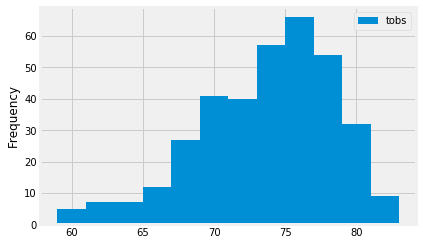

In [257]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(Measurement.date).filter_by(station = 'USC00519281').order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago = one_year_ago.strftime("%Y-%m-%d")
new_df = pd.read_sql_query("select date, tobs from measurement \
where date between '" + one_year_ago +  "' and '" + last_date + "' and station = 'USC00519281' order by date", session.bind)
plt.hist(new_df['tobs'], bins=12)
plt.legend(['tobs'])
plt.ylabel('Frequency')
plt.show()

In [258]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [318]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-03-31', '2017-04-05'))

[(67.0, 74.725, 80.0)]


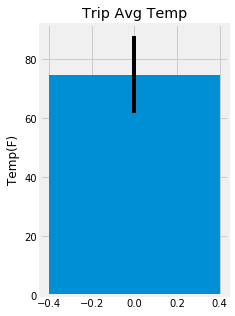

In [319]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip = calc_temps('2017-03-31', '2017-04-05')[0]
fig = plt.figure(figsize=(3,5))
plt.bar(0, my_trip[1], yerr=my_trip[2] - my_trip[0])
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.show()

In [320]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_by_prec = session.query(Station.station,Station.name,Station.latitude,\
                    Station.longitude,Station.elevation,func.sum(Measurement.prcp))\
                    .filter(Measurement.station == Station.station)\
                    .filter(Measurement.date >= '2017-03-31')\
                    .filter(Measurement.date <= '2017-04-05')\
                    .group_by(Measurement.station)\
                    .order_by(func.sum(Measurement.prcp).desc())\
                    .all()
station_by_prec    

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.9000000000000001),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.6699999999999999),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.16),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.16),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

## Optional Challenge Assignment

In [332]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [367]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
my_trip_start = '2017-03-31'
my_trip_length = 6
my_trip_range = [(dt.datetime.strptime(my_trip_start, '%Y-%m-%d') \
                  + dt.timedelta(days=n)).strftime("%Y-%m-%d") \
                  for n in range(my_trip_length)]
my_trip_info = []
for day in my_trip_range:
    day = dt.datetime.strptime(day, '%Y-%m-%d').strftime('%m-%d')
    my_trip_info.append(daily_normals(day))

for t in my_trip_info:
    print(t)

[(61.0, 71.875, 79.0)]
[(60.0, 71.87931034482759, 80.0)]
[(53.0, 71.82142857142857, 79.0)]
[(55.0, 72.2280701754386, 78.0)]
[(58.0, 72.01639344262296, 78.0)]
[(61.0, 72.28813559322033, 80.0)]


In [404]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = [t[0][0] for t in my_trip_info]
tavg = [t[0][1] for t in my_trip_info]
tmax = [t[0][2] for t in my_trip_info]
my_trip_df = pd.DataFrame({'date': my_trip_range, 'tmin': tmin , 'tavg': tavg, 'tmax': tmax})
my_trip_df = my_trip_df.set_index('date')
my_trip_df

,tmin,tavg,tmax
date,,,
2017-03-31,61.0,71.875000,79.0
2017-04-01,60.0,71.879310,80.0
2017-04-02,53.0,71.821429,79.0
2017-04-03,55.0,72.228070,78.0
2017-04-04,58.0,72.016393,78.0
2017-04-05,61.0,72.288136,80.0


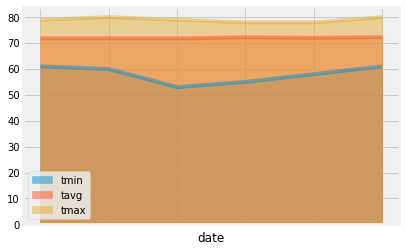

In [406]:
# Plot the daily normals as an area plot with `stacked=False`
my_trip_df.plot.area(stacked=False)
plt.show()